In [1]:
from salishsea_tools import viz_tools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
import xarray as xr
import cmocean.cm as cm
import glob
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
import pandas as pd
import salishsea_tools.river_202108 as rivers

In [2]:
#TODO: fix plot titles
#TODO: make so that I can do this with any river, not just the Nooksack!

In [3]:
fw = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/extractions/SalishSeaCast_river_trace_day_avg_allR_00_40_20120101_20121231.nc')
phys = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/extractions/SalishSeaCast_river_trace_day_avg_allP_00_40_20120101_20121231.nc')
# fw_rivers = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/extractions/SalishSeaCast_river_trace_day_avg_allR_00_40_res1M_20120101_20121231.nc')
# phys_rivers = ??

In [4]:
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
# the mask is 1 where there is water, we want the opposite.  The meshmask has an extra dimension, hence the [0]
tmask = 1 - mesh.tmask[0]

volume = (1-tmask) * mesh.e3t_0[0] * mesh.e1t[0] * mesh.e2t[0]
volume_dims = np.array([volume.to_numpy(), volume.to_numpy()])[0:1] ## do this once, pass volume dims into it

rho_inv = (1/1026)

In [5]:
## define a "global" fps for all the animations
writervideo = animation.FFMpegWriter(fps=10)

## Surface salinity and temperature

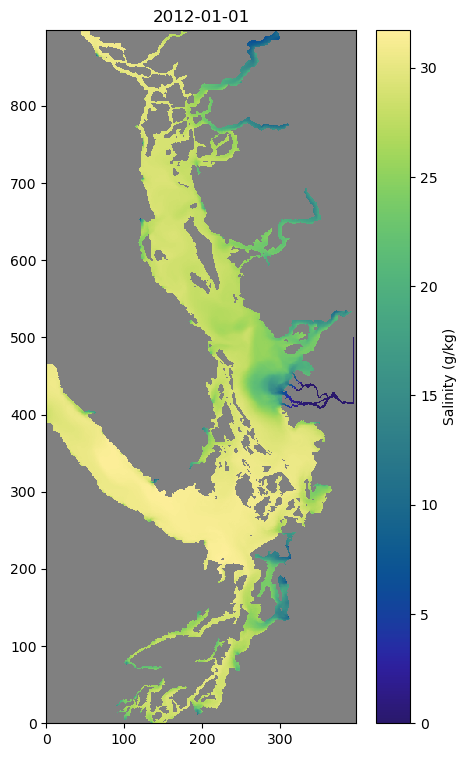

In [6]:
fname = 'vosaline_all_domain_subset_daily_00_00'
writervideo = animation.FFMpegWriter(fps=10)
depth = 0 
cmap = cm.haline
cmap.set_bad('gray')

fig, ax = plt.subplots(1,1, figsize = (5, 9))
salinity = np.ma.masked_array(phys.vosaline[0, depth], mask=tmask[0])
colours = ax.pcolormesh(salinity, cmap=cmap)
cb = fig.colorbar(colours, ax=ax, label='Salinity (g/kg)')

def newframe(frame_num):
    salinity = np.ma.masked_array(phys.vosaline[frame_num, depth], mask=tmask[depth])
    colours.set_array(salinity.ravel())
    dtime = pd.to_datetime(phys['time'].values[frame_num])
    ax.set_title(str(dtime.date()))

ani = FuncAnimation(fig, newframe, frames=len(phys['time']), repeat=False)
ani.save('/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/river_dye_trace/animations/hindcast_auto/{}.mp4'.format(fname), writer=writervideo)

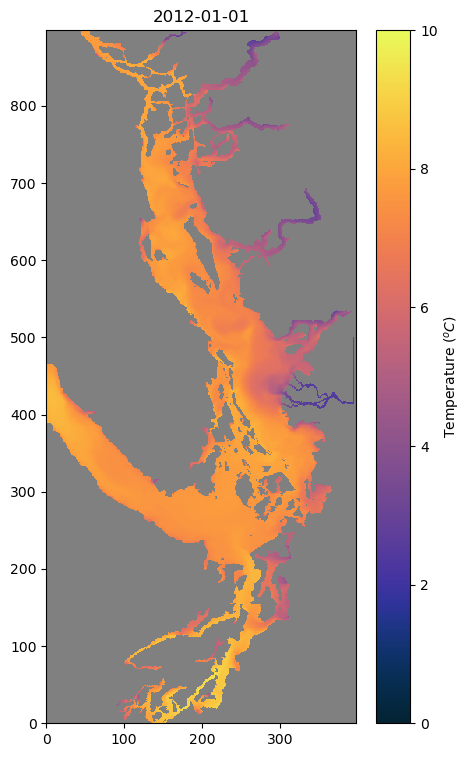

In [7]:
fname = 'votemper_all_domain_subset_daily_00_00'
writervideo = animation.FFMpegWriter(fps=10)
depth = 0 
cmap = cm.thermal
cmap.set_bad('gray')

fig, ax = plt.subplots(1,1, figsize = (5, 9))
temp = np.ma.masked_array(phys.votemper[0, depth], mask=tmask[0])
colours = ax.pcolormesh(temp, vmin=0, vmax=10, cmap=cmap)
cb = fig.colorbar(colours, ax=ax, label=r'Temperature ($^o C$)')

def newframe(frame_num):
    temp = np.ma.masked_array(phys.votemper[frame_num, depth], mask=tmask[0])
    colours.set_array(temp.ravel())
    dtime = pd.to_datetime(phys['time'].values[frame_num])
    ax.set_title(str(dtime.date()))

ani = FuncAnimation(fig, newframe, frames=len(phys['time']), repeat=False)
ani.save('/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/river_dye_trace/animations/hindcast_auto/{}.mp4'.format(fname), writer=writervideo)

## Rivers

In [5]:
def river_box(w_shed, r_call, box_side):
    river_idx = [rivers.prop_dict[w_shed][r_call]['i'], rivers.prop_dict[w_shed][r_call]['j']]
    river_range = [river_idx[0] - box_side, river_idx[0] + box_side, river_idx[1] - box_side, river_idx[1] + box_side]

    if (river_range[0] < 0):
        river_range[0] = 0
        river_range[1] = box_side*2

    if (898 - river_range[1] < 0):
        river_range[0] = 898-box_side*2
        river_range[1] = 898

    if (398 - river_range[3] < 0):
        river_range[2] = 398-box_side*2
        river_range[3] = 398

    return river_range

In [6]:
box_size = 40

# order (CW starting under the Fraser): Nooksack, Skagit, Snohomish, Nisqually, Elwha, Cowichan, Nanaimo, Puntledge, Salmon, Homathko, Squamish
box_dict = {'nooksack': river_box('fraser', 'Nooksack', box_size), 'skagit': river_box('skagit', 'Skagit1', box_size), 'snohomish': river_box('skagit', 'SnohomishAllenQuilceda', box_size), \
            'nisqually': river_box('puget', 'NisquallyMcAllister', box_size), 'elwha': river_box('jdf', 'Elwha', box_size), 'cowichan': river_box('evi_s', 'Cowichan1', box_size), \
            'nanaimo': river_box('evi_s', 'Nanaimo1', box_size), 'puntledge': river_box('evi_s', 'Puntledge', box_size), 'salmon': river_box('evi_n', 'SalmonSayward', box_size), \
            'homathko': river_box('bute', 'Homathko', box_size), 'squamish': river_box('howe', 'Squamish', box_size)}

point_dict = {'nooksack': rivers.prop_dict['fraser']['Nooksack'], 'skagit': rivers.prop_dict['skagit']['Skagit1'], 'snohomish': rivers.prop_dict['skagit']['SnohomishAllenQuilceda'], \
            'nisqually': rivers.prop_dict['puget']['NisquallyMcAllister'], 'elwha': rivers.prop_dict['jdf']['Elwha'], 'cowichan': rivers.prop_dict['evi_s']['Cowichan1'], \
            'nanaimo': rivers.prop_dict['evi_s']['Nanaimo1'], 'puntledge': rivers.prop_dict['evi_s']['Puntledge'], 'salmon': rivers.prop_dict['evi_n']['SalmonSayward'], \
            'homathko': rivers.prop_dict['bute']['Homathko'], 'squamish': rivers.prop_dict['howe']['Squamish']}

In [10]:
# box_size = 40
# # order (CW starting under the Fraser): Nooksack, Skagit, Snohomish, Nisqually, Elwha, Cowichan, Nanaimo, Puntledge, Salmon, Homathko, Squamish
# Nooksack = river_box('fraser', 'Nooksack', box_size)
# Skagit = river_box('skagit', 'Skagit1', box_size)
# Snohomish = river_box('skagit', 'SnohomishAllenQuilceda', box_size)
# Nisqually = river_box('puget', 'NisquallyMcAllister', box_size)
# Elwha = river_box('jdf', 'Elwha', box_size)
# Cowichan = river_box('evi_s', 'Cowichan1', box_size)
# Nanaimo = river_box('evi_s', 'Nanaimo1', box_size)
# Puntledge = river_box('evi_s', 'Puntledge', box_size)
# Salmon = river_box('evi_n', 'SalmonSayward', box_size)
# Homathko = river_box('bute', 'Homathko', box_size)
# Squamish = river_box('howe', 'Squamish', box_size)

In [11]:
# total_freshwater = fw_rivers.nooksack_river + fw_rivers.skagit_river + fw_rivers.snohomish_river + fw_rivers.nisqually_river + fw_rivers.elwha_river + \
#     fw_rivers.cowichan_river + fw_rivers.nanaimo_river + fw_rivers.puntledge_river + fw_rivers.salmon_river + fw_rivers.homathko_river + \
#     fw_rivers.squamish_river + fw_rivers.other_rivers + fw_rivers.fraser_river

# Visualizations of dye

In [7]:
fudge = .0001 # need to add very small number here because we can't do log of zero without weird effects in the masking

## View all dye in the domain

In [8]:
X = np.arange(0,398)
Y = np.arange(0,898)

In [15]:
# fname = 'dye_all_domain_subset_monthly_00_00'
# writervideo = animation.FFMpegWriter(fps=2)
# depth = 0 
# cmap = mpl.colormaps['viridis']
# cmap.set_bad('gray')

# fig, ax = plt.subplots(1,1, figsize = (5, 9))
# subset_rivers = fw_rivers.nooksack_river[0, depth] + fw_rivers.skagit_river[0, depth] + fw_rivers.snohomish_river[0, depth] + fw_rivers.nisqually_river[0, depth] + fw_rivers.elwha_river[0, depth] + \
#     fw_rivers.cowichan_river[0, depth] + fw_rivers.nanaimo_river[0, depth] + fw_rivers.puntledge_river[0, depth] + fw_rivers.salmon_river[0, depth] + fw_rivers.homathko_river[0, depth] + \
#     fw_rivers.squamish_river[0, depth]
# freshwater = np.ma.masked_array(subset_rivers, mask=tmask[depth])
# Z = freshwater + fudge
# colours = ax.pcolormesh(X, Y, Z, norm=colors.LogNorm(vmin=fudge), cmap=cmap)
# cb = fig.colorbar(colours, ax=ax, label='dye')

# def newframe(frame_num):
#     subset_rivers = fw_rivers.nooksack_river[frame_num, depth] + fw_rivers.skagit_river[frame_num, depth] + fw_rivers.snohomish_river[frame_num, depth] + fw_rivers.nisqually_river[frame_num, depth] + fw_rivers.elwha_river[frame_num, depth] + \
#     fw_rivers.cowichan_river[frame_num, depth] + fw_rivers.nanaimo_river[frame_num, depth] + fw_rivers.puntledge_river[frame_num, depth] + fw_rivers.salmon_river[frame_num, depth] + fw_rivers.homathko_river[frame_num, depth] + \
#     fw_rivers.squamish_river[frame_num, depth]

#     freshwater = np.ma.masked_array(subset_rivers, mask=tmask[depth])
#     Z = freshwater + fudge
#     colours.set_array(Z.ravel())
#     dtime = pd.to_datetime(fw_rivers['time'].values[frame_num])
#     ax.set_title('River Subset ' + str(dtime.date()))

# ani = FuncAnimation(fig, newframe, frames=len(fw_rivers['time']), repeat=False)
# ani.save('/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/river_dye_trace/animations/hindcast_auto/{}.mp4'.format(fname), writer=writervideo)

In [16]:
# fname = 'dye_all_domain_other_monthly_00_00'
# writervideo = animation.FFMpegWriter(fps=2)
# depth = 0
# cmap = mpl.colormaps['viridis']
# cmap.set_bad('gray')

# fig, ax = plt.subplots(1,1, figsize = (5, 9))

# freshwater = np.ma.masked_array(fw_rivers.other_rivers[0, depth], mask=tmask[depth])
# Z = freshwater + fudge
# colours = ax.pcolormesh(X, Y, Z, norm=colors.LogNorm(vmin=fudge), cmap=cmap)
# cb = fig.colorbar(colours, ax=ax, label='dye')

# def newframe(frame_num):
#     freshwater = np.ma.masked_array(fw_rivers.other_rivers[frame_num, depth], mask=tmask[depth])
#     Z = freshwater + fudge
#     colours.set_array(Z.ravel())
#     dtime = pd.to_datetime(fw_rivers['time'].values[frame_num])
#     ax.set_title('Other Rivers ' + str(dtime.date()))

# ani = FuncAnimation(fig, newframe, frames=len(fw_rivers['time']), repeat=False)
# ani.save('/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/river_dye_trace/animations/hindcast_auto/{}.mp4'.format(fname), writer=writervideo)

In [17]:
# fname = 'dye_all_domain_fraser_monthly_00_00'
# writervideo = animation.FFMpegWriter(fps=2)
# depth = 0 
# cmap = mpl.colormaps['viridis']
# cmap.set_bad('gray')

# fig, ax = plt.subplots(1,1, figsize = (5, 9))

# freshwater = np.ma.masked_array(fw_rivers.fraser_river[0, depth], mask=tmask[depth])
# Z = freshwater + fudge
# colours = ax.pcolormesh(X, Y, Z, cmap=cmap)
# cb = fig.colorbar(colours, ax=ax, label='dye')

# def newframe(frame_num):
#     freshwater = np.ma.masked_array(fw_rivers.fraser_river[frame_num, depth], mask=tmask[depth])
#     Z = freshwater + fudge
#     colours.set_array(Z.ravel())
#     dtime = pd.to_datetime(fw_rivers['time'].values[frame_num])
#     ax.set_title('Fraser River ' + str(dtime.date()))

# ani = FuncAnimation(fig, newframe, frames=len(fw_rivers['time']), repeat=False)
# ani.save('/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/river_dye_trace/animations/hindcast_auto/{}.mp4'.format(fname), writer=writervideo)

## whole domain for one river

In [8]:
river = 'squamish'
river_call = '{}_river'.format(river)
gridY = np.arange(box_dict[river][0],box_dict[river][1])
gridX = np.arange(box_dict[river][2],box_dict[river][3])

In [29]:
# fname = 'dye_all_domain_{}_monthly_00_00'.format(river)
# writervideo = animation.FFMpegWriter(fps=10)
# depth = 0 
# cmap = mpl.colormaps['viridis']
# cmap.set_bad('gray')

# fig, ax = plt.subplots(1,1, figsize = (5, 9))

# freshwater = np.ma.masked_array(fw_rivers[river_call][0, depth], mask=tmask[depth])
# Z = freshwater + fudge
# colours = ax.pcolormesh(X, Y, Z, norm=colors.LogNorm(vmin=fudge), cmap=cmap)
# cb = fig.colorbar(colours, ax=ax, label='dye')

# def newframe(frame_num):
#     freshwater = np.ma.masked_array(fw_rivers[river_call][frame_num, depth], mask=tmask[depth])
#     Z = freshwater + fudge
#     colours.set_array(Z.ravel())
#     dtime = pd.to_datetime(fw_rivers['time'].values[frame_num])
#     ax.set_title('{} River {}'.format(river, str(dtime.date())))

# ani = FuncAnimation(fig, newframe, frames=len(fw_rivers['time']), repeat=False)
# ani.save('/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/river_dye_trace/animations/hindcast_auto/{}/{}.mp4'.format(river, fname), writer=writervideo)

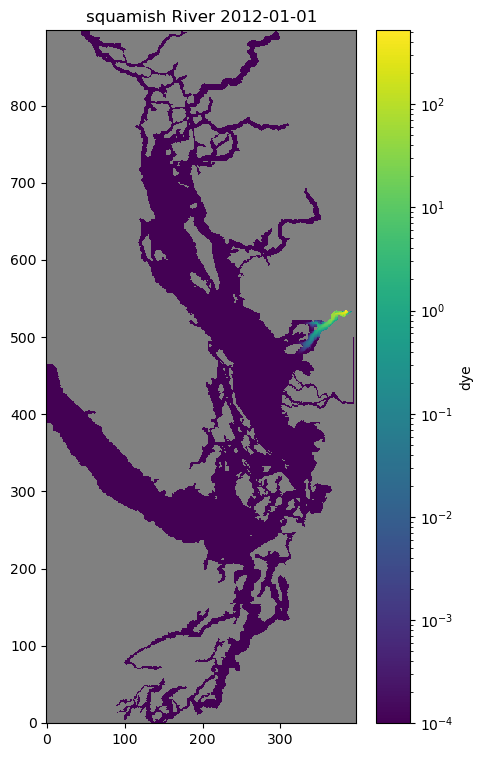

In [20]:
fname = 'dye_all_domain_{}_daily_00_00'.format(river)
writervideo = animation.FFMpegWriter(fps=10)
depth = 0 
cmap = mpl.colormaps['viridis']
cmap.set_bad('gray')

fig, ax = plt.subplots(1,1, figsize = (5, 9))

freshwater = np.ma.masked_array(fw[river_call][0, depth], mask=tmask[depth])
Z = freshwater + fudge
colours = ax.pcolormesh(X, Y, Z, norm=colors.LogNorm(vmin=fudge), cmap=cmap)
cb = fig.colorbar(colours, ax=ax, label='dye')

def newframe(frame_num):
    freshwater = np.ma.masked_array(fw[river_call][frame_num, depth], mask=tmask[depth])
    Z = freshwater + fudge
    colours.set_array(Z.ravel())
    dtime = pd.to_datetime(fw['time'].values[frame_num])
    ax.set_title('{} River {}'.format(river, str(dtime.date())))

ani = FuncAnimation(fig, newframe, frames=len(fw['time']), repeat=False)
ani.save('/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/river_dye_trace/animations/hindcast_auto/{}/{}.mp4'.format(river, fname), writer=writervideo)

## Surface plan views

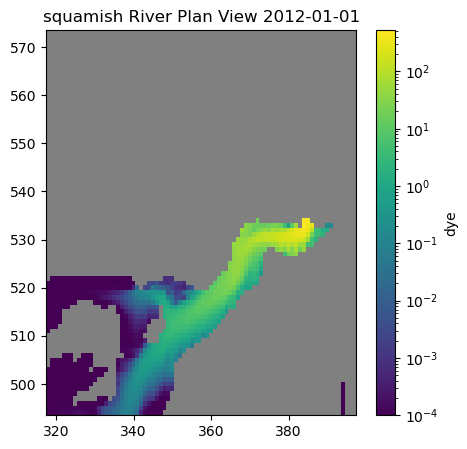

In [21]:
fname = 'dye_sub_domain_{}_daily_00_00'.format(river)
writervideo = animation.FFMpegWriter(fps=10)
depth = 0 
cmap = mpl.colormaps['viridis']
cmap.set_bad('gray')

freshwater = np.ma.masked_array(fw[river_call][0, depth], mask=tmask[0])

X = gridX
Y = gridY
Z = freshwater[box_dict[river][0]:box_dict[river][1], box_dict[river][2]:box_dict[river][3]] + fudge

fig, ax = plt.subplots(1,1, figsize = (5, 5))
colours = ax.pcolormesh(X, Y, Z, norm=colors.LogNorm(vmin=fudge), cmap=cmap)
cb = fig.colorbar(colours, ax=ax, label='dye')

def newframe(frame_num):
    freshwater = np.ma.masked_array(fw[river_call][frame_num, depth], mask=tmask[0])
    Z = freshwater[box_dict[river][0]:box_dict[river][1], box_dict[river][2]:box_dict[river][3]] + fudge

    colours.set_array(Z.ravel())
    dtime = pd.to_datetime(fw['time'].values[frame_num])
    ax.set_title('{} River Plan View {}'.format(river, str(dtime.date())))

ani = FuncAnimation(fig, newframe, frames=len(fw['time']), repeat=False)
ani.save('/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/river_dye_trace/animations/hindcast_auto/{}/{}.mp4'.format(river, fname), writer=writervideo)

## Side slice views

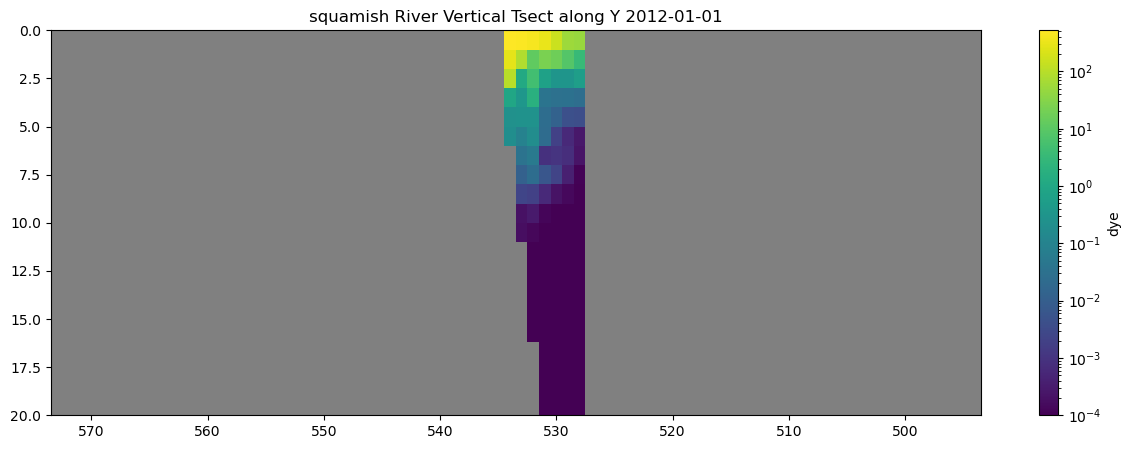

In [35]:
# vertical slice along Y
fname = 'dye_sub_domain_{}_Yslice_daily_00_00'.format(river)
writervideo = animation.FFMpegWriter(fps=10)
jdepth = 20
cmap = mpl.colormaps['viridis']
cmap.set_bad('gray')

freshwater = np.ma.masked_array(fw[river_call][0, :, :, point_dict[river]['j']], mask=tmask[:, :, point_dict[river]['j']])

X = fw.gridY[box_dict[river][0]:box_dict[river][1]]
Y = fw.depth
Z = freshwater[:, box_dict[river][0]:box_dict[river][1]] + fudge

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
colours = ax.pcolormesh(X, Y, Z, norm=colors.LogNorm(vmin=fudge), cmap=cmap)
cb = fig.colorbar(colours, ax=ax, label='dye')

def newframe(frame_num):
    freshwater = np.ma.masked_array(fw[river_call][frame_num, :, :, point_dict[river]['j']], mask=tmask[:, :, point_dict[river]['j']])
    Z = freshwater[:, box_dict[river][0]:box_dict[river][1]] + fudge

    colours.set_array(Z.ravel())
    dtime = pd.to_datetime(fw['time'].values[frame_num])
    ax.set_title('{} River Vertical Tsect along Y {}'.format(river, str(dtime.date())))

ax.set_ylim(0, jdepth)

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

ani = FuncAnimation(fig, newframe, frames=len(fw['time']), repeat=False)
ani.save('/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/river_dye_trace/animations/hindcast_auto/{}/{}.mp4'.format(river, fname), writer=writervideo)

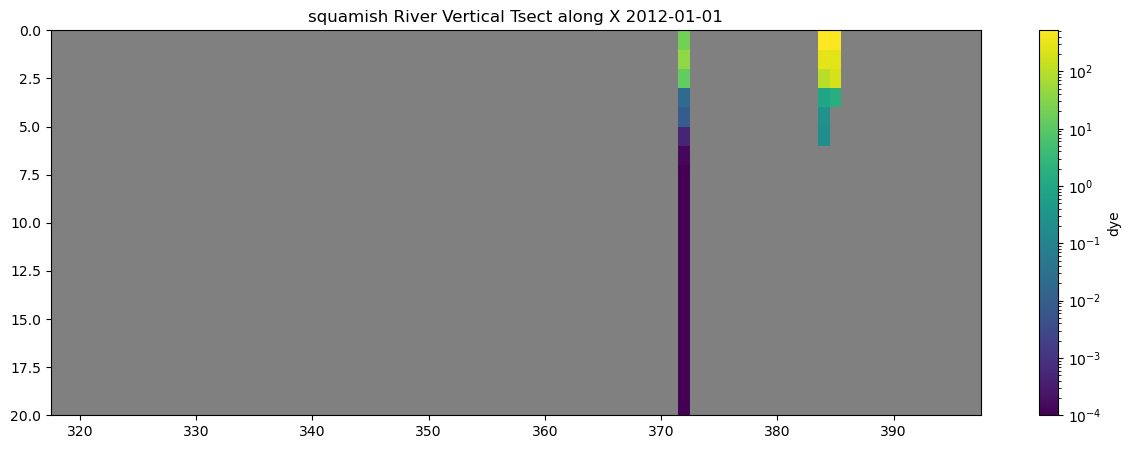

In [36]:
# horizontal slice along X
fname = 'dye_sub_domain_{}_Xslice_daily_00_00'.format(river)
writervideo = animation.FFMpegWriter(fps=10)
depth = 0 
cmap = mpl.colormaps['viridis']
cmap.set_bad('gray')

freshwater = np.ma.masked_array(fw[river_call][0, :, point_dict[river]['i'], :], mask=tmask[:, point_dict[river]['i'], :])

X = fw.gridX[box_dict[river][2]:box_dict[river][3]]
Y = fw.depth
Z = freshwater[:, box_dict[river][2]:box_dict[river][3]] + fudge

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
colours = ax.pcolormesh(X, Y, Z, norm=colors.LogNorm(vmin=fudge), cmap=cmap)
# colours = ax.pcolormesh(X, Y, Z, cmap=cmap)
cb = fig.colorbar(colours, ax=ax, label='dye')


def newframe(frame_num):
    freshwater = np.ma.masked_array(fw[river_call][frame_num, :, point_dict[river]['i'], :], mask=tmask[:, point_dict[river]['i'], :])
    Z = freshwater[:, box_dict[river][2]:box_dict[river][3]] + fudge

    colours.set_array(Z.ravel())
    dtime = pd.to_datetime(fw['time'].values[frame_num])
    ax.set_title('{} River Vertical Tsect along X {}'.format(river, str(dtime.date())))

ax.set_ylim(0, jdepth)
plt.gca().invert_yaxis()

ani = FuncAnimation(fig, newframe, frames=len(fw['time']), repeat=False)
ani.save('/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/river_dye_trace/animations/hindcast_auto/{}/{}.mp4'.format(river, fname), writer=writervideo)

## Combined slice views

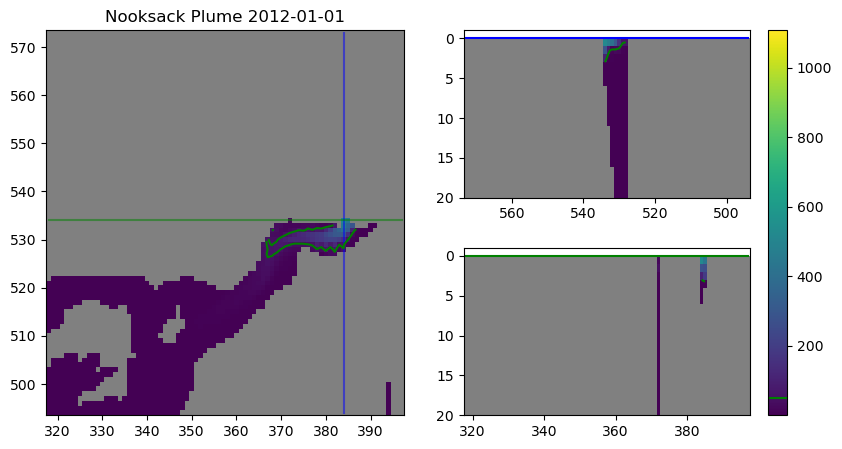

In [38]:
fname = 'dye_sub_domain_{}_combo_daily_00_00'.format(river)
writervideo = animation.FFMpegWriter(fps=10)
depth = 0
jdepth = 20
cmap = mpl.colormaps['viridis']
cmap.set_bad('gray')
cont_vals = [50]

fig = plt.figure(figsize=(10,5))

grid = plt.GridSpec(2,4, wspace=0.4, hspace=0.3)
ax1 = plt.subplot(grid[0:,0:2])
ax2 = plt.subplot(grid[0,2:])
ax3 = plt.subplot(grid[1,2:])

## finding vmax
dye_max = np.nanmax(fw[river_call][:, :, box_dict[river][0]:box_dict[river][1], box_dict[river][2]:box_dict[river][3]].values)

## axs1
freshwater1 = np.ma.masked_array(fw[river_call][0, depth], mask=tmask[0])
X1 = gridX
Y1 = gridY
Z1 = freshwater1[box_dict[river][0]:box_dict[river][1], box_dict[river][2]:box_dict[river][3]] + fudge
# colours1 = ax1.pcolormesh(X1, Y1, Z1, norm=colors.LogNorm(vmin=fudge, vmax=dye_max), cmap=cmap)
colours1 = ax1.pcolormesh(X1, Y1, Z1, vmin=fudge, vmax=dye_max, cmap=cmap)
ax1.plot([point_dict[river]['j'], point_dict[river]['j']], [box_dict[river][0], box_dict[river][1]-1], 'b-', alpha=0.5)
ax1.plot([box_dict[river][2], box_dict[river][3]-1], [point_dict[river]['i'], point_dict[river]['i']], 'g-', alpha=0.5)
cont1 = ax1.contour(X1, Y1, Z1, cont_vals, colors='green')

## axs2
freshwater2 = np.ma.masked_array(fw[river_call][0, :, :, point_dict[river]['j']], mask=tmask[:, :, point_dict[river]['j']])
X2 = np.arange(box_dict[river][0],box_dict[river][1])
Y2 = fw.depth
Z2 = freshwater2[:, box_dict[river][0]:box_dict[river][1]] + fudge
# colours2 = ax2.pcolormesh(X2, Y2, Z2, norm=colors.LogNorm(vmin=fudge, vmax=dye_max), cmap=cmap)
colours2 = ax2.pcolormesh(X2, Y2, Z2, vmin=fudge, vmax=dye_max, cmap=cmap)
ax2.plot([box_dict[river][0], box_dict[river][1]-1],[0,0],'b-')
cont2 = ax2.contour(X2, Y2, Z2, cont_vals, colors='green')
ax2.set_ylim(-1, jdepth)
ax2.invert_yaxis()
ax2.invert_xaxis()

## axs3
freshwater3 = np.ma.masked_array(fw[river_call][0, :, point_dict[river]['i'], :], mask=tmask[:, point_dict[river]['i'], :])
X3 = np.arange(box_dict[river][2],box_dict[river][3])
Y3 = fw.depth
Z3 = freshwater3[:, box_dict[river][2]:box_dict[river][3]] + fudge
# colours3 = ax3.pcolormesh(X3, Y3, Z3, norm=colors.LogNorm(vmin=fudge, vmax=dye_max), cmap=cmap)
colours3 = ax3.pcolormesh(X3, Y3, Z3, vmin=fudge, vmax=dye_max, cmap=cmap)
ax3.plot([box_dict[river][2], box_dict[river][3]-1],[0,0],'g-')
cont3 = ax3.contour(X3, Y3, Z3, cont_vals, colors='green')
ax3.set_ylim(-1, jdepth)
ax3.invert_yaxis()

cbar = fig.colorbar(colours1, ax=[ax2, ax3])
cbar.add_lines(cont1)

def newframe(frame_num):
    dtime = pd.to_datetime(fw['time'].values[frame_num])

    ax1.clear()
    freshwater1 = np.ma.masked_array(fw[river_call][frame_num, depth], mask=tmask[0])
    Z1 = freshwater1[box_dict[river][0]:box_dict[river][1], box_dict[river][2]:box_dict[river][3]] + fudge
    colours1 = ax1.pcolormesh(X1, Y1, Z1, vmin=fudge, vmax=dye_max, cmap=cmap)
    ax1.plot([point_dict[river]['j'], point_dict[river]['j']], [box_dict[river][0], box_dict[river][1]-1], 'b-', alpha=0.5)
    ax1.plot([box_dict[river][2], box_dict[river][3]-1], [point_dict[river]['i'], point_dict[river]['i']], 'g-', alpha=0.5)
    cont1 = ax1.contour(X1, Y1, Z1, cont_vals, colors='green')
    colours1.set_array(Z1.ravel())
    ax1.set_title('Nooksack Plume ' + str(dtime.date()))

    ax2.clear()
    freshwater2 = np.ma.masked_array(fw[river_call][frame_num, :, :, point_dict[river]['j']], mask=tmask[:, :, point_dict[river]['j']])
    Z2 = freshwater2[:, box_dict[river][0]:box_dict[river][1]] + fudge
    colours2 = ax2.pcolormesh(X2, Y2, Z2, vmin=fudge, vmax=dye_max, cmap=cmap)
    colours2.set_array(Z2.ravel())
    ax2.plot([box_dict[river][0], box_dict[river][1]-1],[0,0],'b-')
    cont2 = ax2.contour(X2, Y2, Z2, cont_vals, colors='green')
    ax2.set_ylim(-1, jdepth)
    ax2.invert_yaxis()
    ax2.invert_xaxis()

    ax3.clear()
    freshwater3 = np.ma.masked_array(fw[river_call][frame_num, :, point_dict[river]['i'], :], mask=tmask[:, point_dict[river]['i'], :])
    Z3 = freshwater3[:, box_dict[river][2]:box_dict[river][3]] + fudge
    colours3 = ax3.pcolormesh(X3, Y3, Z3, vmin=fudge, vmax=dye_max, cmap=cmap)
    colours3.set_array(Z3.ravel())
    ax3.plot([box_dict[river][2], box_dict[river][3]-1],[0,0],'g-')
    cont3 = ax3.contour(X3, Y3, Z3, cont_vals, colors='green')
    ax3.set_ylim(-1, jdepth)
    ax3.invert_yaxis()

ani = FuncAnimation(fig, newframe, frames=len(fw['time']), repeat=False)
ani.save('/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/river_dye_trace/animations/hindcast_auto/{}/{}.mp4'.format(river, fname), writer=writervideo)

In [ ]:
# ## this is for the proportion plot
# fig = plt.figure(figsize=(10,5))

# grid = plt.GridSpec(2,4, wspace=0.4, hspace=0.3)
# ax1 = plt.subplot(grid[0:,0:2])
# ax2 = plt.subplot(grid[0,2:])
# ax3 = plt.subplot(grid[1,2:])
# # cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])

# depth = 0 
# cmap = mpl.colormaps['Reds']
# cmap.set_bad('gray')

# ## finding vmax
# dye_max = np.nanmax(Nooksack_proportion[:, :, Nooksack[0]:Nooksack[1], Nooksack[2]:Nooksack[3]].values)

# ## axs1
# freshwater1 = np.ma.masked_array(Nooksack_proportion[0, depth], mask=tmask[0])
# X1 = gridX
# Y1 = gridY
# Z1 = freshwater1[Nooksack[0]:Nooksack[1], Nooksack[2]:Nooksack[3]] + fudge
# # colours1 = ax1.pcolormesh(X1, Y1, Z1, norm=colors.LogNorm(vmin=fudge, vmax=dye_max), cmap=cmap)
# colours1 = ax1.pcolormesh(X1, Y1, Z1, vmin=fudge, vmax=dye_max, cmap=cmap)
# ax1.plot([rivers.prop_dict['fraser']['Nooksack']['j'], rivers.prop_dict['fraser']['Nooksack']['j']], [Nooksack[0], Nooksack[1]-1], 'b-', alpha=0.5)
# ax1.plot([Nooksack[2], Nooksack[3]-1], [rivers.prop_dict['fraser']['Nooksack']['i'], rivers.prop_dict['fraser']['Nooksack']['i']], 'g-', alpha=0.5)
# cont1 = ax1.contour(X1, Y1, Z1, [0.5], colors='green')

# ## axs2
# freshwater2 = np.ma.masked_array(Nooksack_proportion[0, :, :, rivers.prop_dict['fraser']['Nooksack']['j']], mask=tmask[:, :, rivers.prop_dict['fraser']['Nooksack']['j']])
# X2 = np.arange(Nooksack[0],Nooksack[1])
# Y2 = fw_rivers.deptht
# Z2 = freshwater2[:, Nooksack[0]:Nooksack[1]] + fudge
# # colours2 = ax2.pcolormesh(X2, Y2, Z2, norm=colors.LogNorm(vmin=fudge, vmax=dye_max), cmap=cmap)
# colours2 = ax2.pcolormesh(X2, Y2, Z2, vmin=fudge, vmax=dye_max, cmap=cmap)
# ax2.plot([Nooksack[0], Nooksack[1]-1],[0,0],'b-')
# cont2 = ax2.contour(X2, Y2, Z2, [0.5], colors='green')
# ax2.set_ylim(-1, 20)
# ax2.invert_yaxis()
# ax2.invert_xaxis()

# ## axs3
# freshwater3 = np.ma.masked_array(Nooksack_proportion[0, :, rivers.prop_dict['fraser']['Nooksack']['i'], :], mask=tmask[:, rivers.prop_dict['fraser']['Nooksack']['i'], :])
# X3 = np.arange(Nooksack[2],Nooksack[3])
# Y3 = fw_rivers.deptht
# Z3 = freshwater3[:, Nooksack[2]:Nooksack[3]] + fudge
# # colours3 = ax3.pcolormesh(X3, Y3, Z3, norm=colors.LogNorm(vmin=fudge, vmax=dye_max), cmap=cmap)
# colours3 = ax3.pcolormesh(X3, Y3, Z3, vmin=fudge, vmax=dye_max, cmap=cmap)
# ax3.plot([Nooksack[2], Nooksack[3]-1],[0,0],'g-')
# cont3 = ax3.contour(X3, Y3, Z3, [0.5], colors='green')
# ax3.set_ylim(-1, 20)
# ax3.invert_yaxis()

# cbar = fig.colorbar(colours1, ax=[ax2, ax3])
# cbar.add_lines(cont1)
# # fig.colorbar(colours1, ax=ax1, location='left')

# def newframe(frame_num):
#     dtime = pd.to_datetime(fw_rivers['time_counter'].values[frame_num])

#     ax1.clear()
#     # if frame_num != 0:
#     #     cont1.remove()
#     freshwater1 = np.ma.masked_array(Nooksack_proportion[frame_num, depth], mask=tmask[0])
#     Z1 = freshwater1[Nooksack[0]:Nooksack[1], Nooksack[2]:Nooksack[3]] + fudge
#     colours1 = ax1.pcolormesh(X1, Y1, Z1, vmin=fudge, vmax=dye_max, cmap=cmap)
#     ax1.plot([rivers.prop_dict['fraser']['Nooksack']['j'], rivers.prop_dict['fraser']['Nooksack']['j']], [Nooksack[0], Nooksack[1]-1], 'b-', alpha=0.5)
#     ax1.plot([Nooksack[2], Nooksack[3]-1], [rivers.prop_dict['fraser']['Nooksack']['i'], rivers.prop_dict['fraser']['Nooksack']['i']], 'g-', alpha=0.5)
#     cont1 = ax1.contour(X1, Y1, Z1, [0.5], colors='green')
#     colours1.set_array(Z1.ravel())
#     ax1.set_title('Nooksack Plume ' + str(dtime.date()))

#     ax2.clear()
#     freshwater2 = np.ma.masked_array(Nooksack_proportion[frame_num, :, :, rivers.prop_dict['fraser']['Nooksack']['j']], mask=tmask[:, :, rivers.prop_dict['fraser']['Nooksack']['j']])
#     Z2 = freshwater2[:, Nooksack[0]:Nooksack[1]] + fudge
#     colours2 = ax2.pcolormesh(X2, Y2, Z2, vmin=fudge, vmax=dye_max, cmap=cmap)
#     colours2.set_array(Z2.ravel())
#     ax2.plot([Nooksack[0], Nooksack[1]-1],[0,0],'b-')
#     cont2 = ax2.contour(X2, Y2, Z2, [0.5], colors='green')
#     ax2.set_ylim(-1, 20)
#     ax2.invert_yaxis()
#     ax2.invert_xaxis()

#     # freshwater2 = np.ma.masked_array(Nooksack_proportion[frame_num, :, :, rivers.prop_dict['fraser']['Nooksack']['j']], mask=tmask[:, :, rivers.prop_dict['fraser']['Nooksack']['j']])
#     # Z2 = freshwater2[:, Nooksack[0]:Nooksack[1]] + fudge
#     # colours2.set_array(Z2.ravel())
#     # ax2.set_ylim(-1, 20)
#     # ax2.invert_yaxis()
#     # # ax2.invert_xaxis()

#     ax3.clear()
#     freshwater3 = np.ma.masked_array(Nooksack_proportion[frame_num, :, rivers.prop_dict['fraser']['Nooksack']['i'], :], mask=tmask[:, rivers.prop_dict['fraser']['Nooksack']['i'], :])
#     Z3 = freshwater3[:, Nooksack[2]:Nooksack[3]] + fudge
#     colours3 = ax3.pcolormesh(X3, Y3, Z3, vmin=fudge, vmax=dye_max, cmap=cmap)
#     colours3.set_array(Z3.ravel())
#     ax3.plot([Nooksack[2], Nooksack[3]-1],[0,0],'g-')
#     cont3 = ax3.contour(X3, Y3, Z3, [0.5], colors='green')
#     ax3.set_ylim(-1, 20)
#     ax3.invert_yaxis()

#     # freshwater3 = np.ma.masked_array(Nooksack_proportion[frame_num, :, rivers.prop_dict['fraser']['Nooksack']['i'], :], mask=tmask[:, rivers.prop_dict['fraser']['Nooksack']['i'], :])
#     # Z3 = freshwater3[:, Nooksack[2]:Nooksack[3]] + fudge
#     # colours3.set_array(Z3.ravel())
#     # ax3.set_ylim(-1, 20)
#     # ax3.invert_yaxis()

# ani = FuncAnimation(fig, newframe, frames=len(fnames_phys), repeat=False)
# # ani.save('animations/three_plot_slices_prop_cont.mp4', writer=writervideo)

In [ ]:
# depth = 0 
# cmap = mpl.colormaps['Reds']
# cmap.set_bad('gray')

# freshwater = np.ma.masked_array(fw_rivers.nooksack_river[0, depth], mask=tmask[0])

# X = gridX
# Y = gridY
# Z = freshwater[Nooksack[0]:Nooksack[1], Nooksack[2]:Nooksack[3]] + fudge

# # fig, ax = plt.subplots(1,1, figsize = (5, 5))
# fig, ax = plt.subplots(2,2, figsize = (5, 5))
# colours = ax[0,0].pcolormesh(X, Y, Z, norm=colors.LogNorm(vmin=fudge), cmap=cmap)
# cb = fig.colorbar(colours, ax=ax, label='dye')

# Sum views

In [9]:
box_depths = np.array(mesh.e3t_0[0][:, 518, 238])
box_vols = np.array(volume[:, 518, 238])  #TODO implement this

In [10]:
jdepth = 40
depth = 0
fw[river_call][0, depth]

<xarray.DataArray 'squamish_river' (gridY: 898, gridX: 398)>
[357404 values with dtype=float32]
Coordinates:
    time     datetime64[ns] 2012-01-01T12:00:00
    depth    float32 0.5
  * gridY    (gridY) int64 0 1 2 3 4 5 6 7 8 ... 890 891 892 893 894 895 896 897
  * gridX    (gridX) int64 0 1 2 3 4 5 6 7 8 ... 390 391 392 393 394 395 396 397
Attributes:
    standard_name:  squamish_river
    long_name:      Squamish River
    units:          1

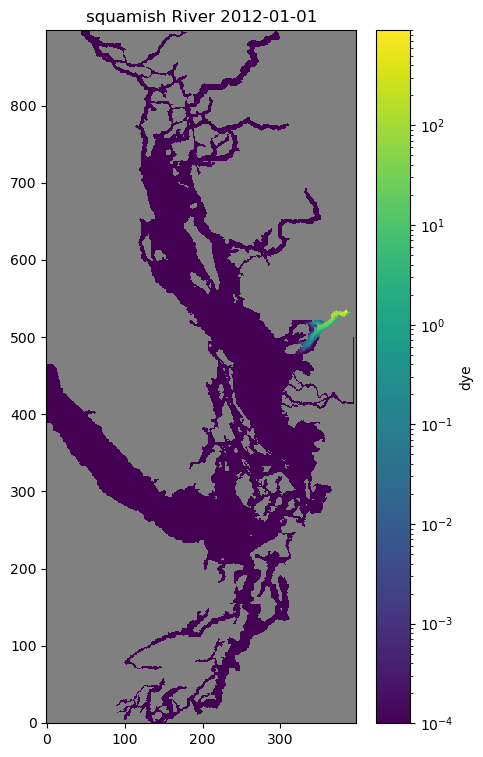

In [14]:
jdepth = 40
fname = 'dye_all_domain_{}_daily_00_{}_sum'.format(river, jdepth)
writervideo = animation.FFMpegWriter(fps=10)
depth = 0
cmap = mpl.colormaps['viridis']
cmap.set_bad('gray')

fig, ax = plt.subplots(1,1, figsize = (5, 9))

freshwater = np.ma.masked_array(fw[river_call][0, depth:jdepth].sum(axis=0), mask=tmask[depth])
Z = freshwater + fudge
colours = ax.pcolormesh(X, Y, Z, norm=colors.LogNorm(vmin=fudge), cmap=cmap)
cb = fig.colorbar(colours, ax=ax, label='dye')

def newframe(frame_num):
    freshwater = np.ma.masked_array(fw[river_call][frame_num, depth:jdepth].sum(axis=0), mask=tmask[depth])
    Z = freshwater + fudge
    colours.set_array(Z.ravel())
    dtime = pd.to_datetime(fw['time'].values[frame_num])
    ax.set_title('{} River {}'.format(river, str(dtime.date())))

ani = FuncAnimation(fig, newframe, frames=len(fw['time']), repeat=False)
ani.save('/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/river_dye_trace/animations/hindcast_auto/{}/{}.mp4'.format(river, fname), writer=writervideo)

In [11]:
fw[river_call][0].sum(axis=2)

<xarray.DataArray 'squamish_river' (depth: 40, gridY: 898)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
    time     datetime64[ns] 2012-01-01T12:00:00
  * depth    (depth) float32 0.5 1.5 2.5 3.5 4.5 ... 360.7 387.6 414.5 441.5
  * gridY    (gridY) int64 0 1 2 3 4 5 6 7 8 ... 890 891 892 893 894 895 896 897

In [16]:
fw[river_call][0, :, :, point_dict[river]['j']]

<xarray.DataArray 'squamish_river' (depth: 40, gridY: 898)>
[35920 values with dtype=float32]
Coordinates:
    time     datetime64[ns] 2012-01-01T12:00:00
  * depth    (depth) float32 0.5 1.5 2.5 3.5 4.5 ... 360.7 387.6 414.5 441.5
  * gridY    (gridY) int64 0 1 2 3 4 5 6 7 8 ... 890 891 892 893 894 895 896 897
    gridX    int64 384
Attributes:
    standard_name:  squamish_river
    long_name:      Squamish River
    units:          1

/tmp/ipykernel_559253/2643167265.py:77: UserWarning: No contour levels were found within the data range.
  cont2 = ax2.contour(X2, Y2, Z2, cont_vals, colors='green')
/tmp/ipykernel_559253/2643167265.py:77: UserWarning: No contour levels were found within the data range.
  cont2 = ax2.contour(X2, Y2, Z2, cont_vals, colors='green')
/tmp/ipykernel_559253/2643167265.py:77: UserWarning: No contour levels were found within the data range.
  cont2 = ax2.contour(X2, Y2, Z2, cont_vals, colors='green')
/tmp/ipykernel_559253/2643167265.py:77: UserWarning: No contour levels were found within the data range.
  cont2 = ax2.contour(X2, Y2, Z2, cont_vals, colors='green')
/tmp/ipykernel_559253/2643167265.py:77: UserWarning: No contour levels were found within the data range.
  cont2 = ax2.contour(X2, Y2, Z2, cont_vals, colors='green')
/tmp/ipykernel_559253/2643167265.py:77: UserWarning: No contour levels were found within the data range.
  cont2 = ax2.contour(X2, Y2, Z2, cont_vals, colors='green')
/tmp

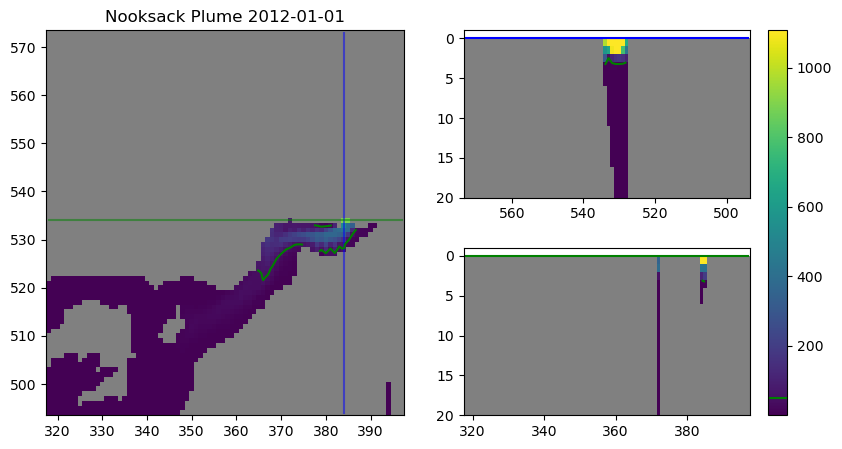

In [17]:
jdepth = 20
fname = 'dye_sub_domain_{}_combo_daily_00_{}_sum'.format(river, jdepth)
writervideo = animation.FFMpegWriter(fps=10)
depth = 0
cmap = mpl.colormaps['viridis']
cmap.set_bad('gray')
cont_vals = [300]

fig = plt.figure(figsize=(10,5))

grid = plt.GridSpec(2,4, wspace=0.4, hspace=0.3)
ax1 = plt.subplot(grid[0:,0:2])
ax2 = plt.subplot(grid[0,2:])
ax3 = plt.subplot(grid[1,2:])

## finding vmax
dye_max = np.nanmax(fw[river_call][:, :, box_dict[river][0]:box_dict[river][1], box_dict[river][2]:box_dict[river][3]].values)

## axs1
freshwater1 = np.ma.masked_array(fw[river_call][0, depth:jdepth].sum(axis=0), mask=tmask[0])
X1 = gridX
Y1 = gridY
Z1 = freshwater1[box_dict[river][0]:box_dict[river][1], box_dict[river][2]:box_dict[river][3]] + fudge
# colours1 = ax1.pcolormesh(X1, Y1, Z1, norm=colors.LogNorm(vmin=fudge, vmax=dye_max), cmap=cmap)
colours1 = ax1.pcolormesh(X1, Y1, Z1, vmin=fudge, vmax=dye_max, cmap=cmap)
ax1.plot([point_dict[river]['j'], point_dict[river]['j']], [box_dict[river][0], box_dict[river][1]-1], 'b-', alpha=0.5)
ax1.plot([box_dict[river][2], box_dict[river][3]-1], [point_dict[river]['i'], point_dict[river]['i']], 'g-', alpha=0.5)
cont1 = ax1.contour(X1, Y1, Z1, cont_vals, colors='green')

## axs2
freshwater2 = np.ma.masked_array(fw[river_call][0].sum(axis=2), mask=tmask[:, :, point_dict[river]['j']])
X2 = np.arange(box_dict[river][0],box_dict[river][1])
Y2 = fw.depth
Z2 = freshwater2[:, box_dict[river][0]:box_dict[river][1]] + fudge
# colours2 = ax2.pcolormesh(X2, Y2, Z2, norm=colors.LogNorm(vmin=fudge, vmax=dye_max), cmap=cmap)
colours2 = ax2.pcolormesh(X2, Y2, Z2, vmin=fudge, vmax=dye_max, cmap=cmap)
ax2.plot([box_dict[river][0], box_dict[river][1]-1],[0,0],'b-')
cont2 = ax2.contour(X2, Y2, Z2, cont_vals, colors='green')
ax2.set_ylim(-1, jdepth)
ax2.invert_yaxis()
ax2.invert_xaxis()

## axs3
freshwater3 = np.ma.masked_array(fw[river_call][0].sum(axis=1), mask=tmask[:, point_dict[river]['i'], :])
X3 = np.arange(box_dict[river][2],box_dict[river][3])
Y3 = fw.depth
Z3 = freshwater3[:, box_dict[river][2]:box_dict[river][3]] + fudge
# colours3 = ax3.pcolormesh(X3, Y3, Z3, norm=colors.LogNorm(vmin=fudge, vmax=dye_max), cmap=cmap)
colours3 = ax3.pcolormesh(X3, Y3, Z3, vmin=fudge, vmax=dye_max, cmap=cmap)
ax3.plot([box_dict[river][2], box_dict[river][3]-1],[0,0],'g-')
cont3 = ax3.contour(X3, Y3, Z3, cont_vals, colors='green')
ax3.set_ylim(-1, jdepth)
ax3.invert_yaxis()

cbar = fig.colorbar(colours1, ax=[ax2, ax3])
cbar.add_lines(cont1)

def newframe(frame_num):
    dtime = pd.to_datetime(fw['time'].values[frame_num])

    ax1.clear()
    freshwater1 = np.ma.masked_array(fw[river_call][frame_num, depth:jdepth].sum(axis=0), mask=tmask[0])
    Z1 = freshwater1[box_dict[river][0]:box_dict[river][1], box_dict[river][2]:box_dict[river][3]] + fudge
    colours1 = ax1.pcolormesh(X1, Y1, Z1, vmin=fudge, vmax=dye_max, cmap=cmap)
    ax1.plot([point_dict[river]['j'], point_dict[river]['j']], [box_dict[river][0], box_dict[river][1]-1], 'b-', alpha=0.5)
    ax1.plot([box_dict[river][2], box_dict[river][3]-1], [point_dict[river]['i'], point_dict[river]['i']], 'g-', alpha=0.5)
    cont1 = ax1.contour(X1, Y1, Z1, cont_vals, colors='green')
    colours1.set_array(Z1.ravel())
    ax1.set_title('Nooksack Plume ' + str(dtime.date()))

    ax2.clear()
    freshwater2 = np.ma.masked_array(fw[river_call][frame_num].sum(axis=2), mask=tmask[:, :, point_dict[river]['j']])
    Z2 = freshwater2[:, box_dict[river][0]:box_dict[river][1]] + fudge
    colours2 = ax2.pcolormesh(X2, Y2, Z2, vmin=fudge, vmax=dye_max, cmap=cmap)
    colours2.set_array(Z2.ravel())
    ax2.plot([box_dict[river][0], box_dict[river][1]-1],[0,0],'b-')
    cont2 = ax2.contour(X2, Y2, Z2, cont_vals, colors='green')
    ax2.set_ylim(-1, jdepth)
    ax2.invert_yaxis()
    ax2.invert_xaxis()

    ax3.clear()
    freshwater3 = np.ma.masked_array(fw[river_call][frame_num].sum(axis=1), mask=tmask[:, point_dict[river]['i'], :])
    Z3 = freshwater3[:, box_dict[river][2]:box_dict[river][3]] + fudge
    colours3 = ax3.pcolormesh(X3, Y3, Z3, vmin=fudge, vmax=dye_max, cmap=cmap)
    colours3.set_array(Z3.ravel())
    ax3.plot([box_dict[river][2], box_dict[river][3]-1],[0,0],'g-')
    cont3 = ax3.contour(X3, Y3, Z3, cont_vals, colors='green')
    ax3.set_ylim(-1, jdepth)
    ax3.invert_yaxis()

ani = FuncAnimation(fig, newframe, frames=len(fw['time']), repeat=False)
ani.save('/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/river_dye_trace/animations/hindcast_auto/{}/{}.mp4'.format(river, fname), writer=writervideo)

In [ ]:
# sum_size = 30

# fig = plt.figure(figsize=(10,5))

# grid = plt.GridSpec(2,4, wspace=0.4, hspace=0.3)
# ax1 = plt.subplot(grid[0:,0:2])
# ax2 = plt.subplot(grid[0,2:])
# ax3 = plt.subplot(grid[1,2:])
# # cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])

# depth = 0 
# cmap = mpl.colormaps['Reds']
# cmap.set_bad('gray')

# ## finding vmax
# # dye_max = np.nanmax(Nooksack_proportion[:, :, Nooksack[0]:Nooksack[1], Nooksack[2]:Nooksack[3]].values)
# dye_max = 600

# ## axs1
# # freshwater1 = np.ma.masked_array(Nooksack_proportion[0, depth], mask=tmask[0])
# freshwater1 = np.ma.masked_array(fw_rivers.nooksack_river[0, :], mask=tmask[:])
# freshwater1 = freshwater.sum(axis=0)
# X1 = gridX
# Y1 = gridY
# Z1 = freshwater1[Nooksack[0]:Nooksack[1], Nooksack[2]:Nooksack[3]] + fudge
# colours1 = ax1.pcolormesh(X1, Y1, Z1, vmin=fudge, vmax=dye_max, cmap=cmap)
# ax1.plot([rivers.prop_dict['fraser']['Nooksack']['j'], rivers.prop_dict['fraser']['Nooksack']['j']], [Nooksack[0], Nooksack[1]-1], 'b-', alpha=0.5)
# ax1.plot([Nooksack[2], Nooksack[3]-1], [rivers.prop_dict['fraser']['Nooksack']['i'], rivers.prop_dict['fraser']['Nooksack']['i']], 'g-', alpha=0.5)
# cont1 = ax1.contour(X1, Y1, Z1, [0.5], colors='green')

# ## axs2
# # freshwater2 = np.ma.masked_array(Nooksack_proportion[0, :, :, rivers.prop_dict['fraser']['Nooksack']['j']], mask=tmask[:, :, rivers.prop_dict['fraser']['Nooksack']['j']])
# freshwater2 = np.ma.masked_array(fw_rivers.nooksack_river[0, :, :, :], mask=tmask[:, :, :])
# X2 = np.arange(Nooksack[0],Nooksack[1])
# Y2 = fw_rivers.deptht
# # Z2 = freshwater2[:, Nooksack[0]:Nooksack[1]] + fudge
# Z2 = np.ma.masked_array(freshwater2[:, Nooksack[0]:Nooksack[1], rivers.prop_dict['fraser']['Nooksack']['j']-sum_size:rivers.prop_dict['fraser']['Nooksack']['j']+sum_size].sum(axis=2), mask=tmask[:, Nooksack[0]:Nooksack[1], rivers.prop_dict['fraser']['Nooksack']['j']])
# colours2 = ax2.pcolormesh(X2, Y2, Z2, vmin=fudge, vmax=dye_max, cmap=cmap)
# ax2.plot([Nooksack[0], Nooksack[1]-1],[0,0],'b-')
# cont2 = ax2.contour(X2, Y2, Z2, [0.5], colors='green')
# ax2.set_ylim(-1, 20)
# ax2.invert_yaxis()
# ax2.invert_xaxis()

# ## axs3
# # freshwater3 = np.ma.masked_array(Nooksack_proportion[0, :, rivers.prop_dict['fraser']['Nooksack']['i'], :], mask=tmask[:, rivers.prop_dict['fraser']['Nooksack']['i'], :])
# freshwater3 = np.ma.masked_array(fw_rivers.nooksack_river[0, :, :, :], mask=tmask[:, :, :])
# X3 = np.arange(Nooksack[2],Nooksack[3])
# Y3 = fw_rivers.deptht
# # Z3 = freshwater3[:, Nooksack[2]:Nooksack[3]] + fudge
# Z3 = np.ma.masked_array(freshwater3[:, rivers.prop_dict['fraser']['Nooksack']['i']-sum_size:rivers.prop_dict['fraser']['Nooksack']['i']+sum_size, Nooksack[2]:Nooksack[3]].sum(axis=1), mask=tmask[:, rivers.prop_dict['fraser']['Nooksack']['i'], Nooksack[2]:Nooksack[3]])
# colours3 = ax3.pcolormesh(X3, Y3, Z3, vmin=fudge, vmax=dye_max, cmap=cmap)
# ax3.plot([Nooksack[2], Nooksack[3]-1],[0,0],'g-')
# cont3 = ax3.contour(X3, Y3, Z3, [0.5], colors='green')
# ax3.set_ylim(-1, 20)
# ax3.invert_yaxis()

# cbar = fig.colorbar(colours1, ax=[ax2, ax3])
# cbar.add_lines(cont1)

# def newframe(frame_num):
#     dtime = pd.to_datetime(fw_rivers['time_counter'].values[frame_num])

#     ax1.clear()
#     # if frame_num != 0:
#     #     cont1.remove()
#     freshwater1 = np.ma.masked_array(fw_rivers.nooksack_river[frame_num, :], mask=tmask[:])
#     freshwater1 = freshwater1.sum(axis=0)
#     Z1 = freshwater1[Nooksack[0]:Nooksack[1], Nooksack[2]:Nooksack[3]] + fudge
#     colours1 = ax1.pcolormesh(X1, Y1, Z1, vmin=fudge, vmax=dye_max, cmap=cmap)
#     ax1.plot([rivers.prop_dict['fraser']['Nooksack']['j'], rivers.prop_dict['fraser']['Nooksack']['j']], [Nooksack[0], Nooksack[1]-1], 'b-', alpha=0.5)
#     ax1.plot([Nooksack[2], Nooksack[3]-1], [rivers.prop_dict['fraser']['Nooksack']['i'], rivers.prop_dict['fraser']['Nooksack']['i']], 'g-', alpha=0.5)
#     cont1 = ax1.contour(X1, Y1, Z1, [300], colors='green')
#     colours1.set_array(Z1.ravel())
#     ax1.set_title('Nooksack Plume ' + str(dtime.date()))

#     ax2.clear()
#     freshwater2 = np.ma.masked_array(fw_rivers.nooksack_river[frame_num, :, :, :], mask=tmask[:, :, :])
#     Z2 = np.ma.masked_array(freshwater2[:, Nooksack[0]:Nooksack[1], rivers.prop_dict['fraser']['Nooksack']['j']-sum_size:rivers.prop_dict['fraser']['Nooksack']['j']+sum_size].sum(axis=2), mask=tmask[:, Nooksack[0]:Nooksack[1], rivers.prop_dict['fraser']['Nooksack']['j']])
#     colours2 = ax2.pcolormesh(X2, Y2, Z2, vmin=fudge, vmax=dye_max, cmap=cmap)
#     colours2.set_array(Z2.ravel())
#     ax2.plot([Nooksack[0], Nooksack[1]-1],[0,0],'b-')
#     cont2 = ax2.contour(X2, Y2, Z2, [300], colors='green')
#     ax2.set_ylim(-1, 20)
#     ax2.invert_yaxis()
#     ax2.invert_xaxis()

#     ax3.clear()
#     freshwater3 = np.ma.masked_array(fw_rivers.nooksack_river[frame_num, :, :, :], mask=tmask[:, :, :])
#     Z3 = np.ma.masked_array(freshwater3[:, rivers.prop_dict['fraser']['Nooksack']['i']-sum_size:rivers.prop_dict['fraser']['Nooksack']['i']+sum_size, Nooksack[2]:Nooksack[3]].sum(axis=1), mask=tmask[:, rivers.prop_dict['fraser']['Nooksack']['i'], Nooksack[2]:Nooksack[3]])
#     colours3 = ax3.pcolormesh(X3, Y3, Z3, vmin=fudge, vmax=dye_max, cmap=cmap)
#     colours3.set_array(Z3.ravel())
#     ax3.plot([Nooksack[2], Nooksack[3]-1],[0,0],'g-')
#     cont3 = ax3.contour(X3, Y3, Z3, [300], colors='green')
#     ax3.set_ylim(-1, 20)
#     ax3.invert_yaxis()

# ani = FuncAnimation(fig, newframe, frames=len(fnames_phys), repeat=False)
# # ani.save('animations/three_plot_slices_prop_cont_sum.mp4', writer=writervideo)
# HTML(ani.to_jshtml())

In [ ]:
# tstep = 0

# cmap = mpl.colormaps['Reds']
# cmap.set_bad('gray')
# fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# freshwater = np.ma.masked_array(fw_rivers.nooksack_river[tstep, :], mask=tmask[:])
# freshwater = freshwater.sum(axis=0)

# X = gridX
# Y = gridY
# Z = freshwater[Nooksack[0]:Nooksack[1], Nooksack[2]:Nooksack[3]] + fudge

# colours = ax.pcolormesh(X, Y, Z, norm=colors.LogNorm(vmin=fudge), cmap=cmap)
# cb = fig.colorbar(colours, ax=ax)
# cb.set_label('freshwater nooksack')
# ax.set_title('Plan Sum \nTimestep = {}'.format(str(tstep)))

In [ ]:
# # vertical slice sum
# sum_size = 30
# tstep = 0

# cmap = mpl.colormaps['Reds']
# cmap.set_bad('gray')
# fig, ax = plt.subplots(1, 1, figsize=(15, 5))
# freshwater = np.ma.masked_array(fw_rivers.nooksack_river[tstep, :, :, :], mask=tmask[:, :, :])

# X = fw_rivers.nav_lat[Nooksack[0]:Nooksack[1], rivers.prop_dict['fraser']['Nooksack']['j']+1]
# Y = fw_rivers.deptht
# Z = np.ma.masked_array(freshwater[:, Nooksack[0]:Nooksack[1], rivers.prop_dict['fraser']['Nooksack']['j']-sum_size:rivers.prop_dict['fraser']['Nooksack']['j']+sum_size].sum(axis=2), mask=tmask[:, Nooksack[0]:Nooksack[1], rivers.prop_dict['fraser']['Nooksack']['j']])

# colours = ax.pcolormesh(X, Y, Z, norm=colors.LogNorm(vmin=fudge), cmap=cmap)

# cb = fig.colorbar(colours, ax=ax)
# cb.set_label('freshwater nooksack')
# ax.set_title('Slice Sum \nTimestep = {}'.format(str(tstep)))
# ax.set_ylim(0, 20)

# plt.gca().invert_yaxis()
# plt.gca().invert_xaxis()

In [ ]:
# # horizontal slice sum
# sum_size = 30
# tstep = 0

# cmap = mpl.colormaps['Reds']
# cmap.set_bad('gray')
# fig, ax = plt.subplots(1, 1, figsize=(15, 5))
# freshwater = np.ma.masked_array(fw_rivers.nooksack_river[tstep, :, :, :], mask=tmask[:, :, :])

# X = fw_rivers.nav_lon[rivers.prop_dict['fraser']['Nooksack']['i']+1, Nooksack[2]:Nooksack[3]]
# Y = fw_rivers.deptht
# Z = np.ma.masked_array(freshwater[:, rivers.prop_dict['fraser']['Nooksack']['i']-sum_size:rivers.prop_dict['fraser']['Nooksack']['i']+sum_size, Nooksack[2]:Nooksack[3]].sum(axis=1), mask=tmask[:, rivers.prop_dict['fraser']['Nooksack']['i'], Nooksack[2]:Nooksack[3]])

# colours = ax.pcolormesh(X, Y, Z, norm=colors.LogNorm(vmin=fudge), cmap=cmap)

# cb = fig.colorbar(colours, ax=ax)
# cb.set_label('freshwater nooksack')
# ax.set_title('Slice Sum \nTimestep = {}'.format(str(tstep)))
# ax.set_ylim(0, 20)

# plt.gca().invert_yaxis()

# Surface velocity (maybe bring this back later to look at where water is going, but more interested in other things right now)

In [ ]:
# zoom_fac = 13
# tstep = 0


# vel_mag = np.sqrt(vvels.vomecrty[tstep, 0]**2 + vvels.vomecrty[tstep, 0]**2)

# cmap = cm.speed
# cmap.set_bad('gray')
# fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# u_vels = np.ma.masked_array(uvels.vozocrtx[tstep, 0], mask=tmask[0])[Nooksack[0]:Nooksack[1], Nooksack[2]:Nooksack[3]]
# v_vels = np.ma.masked_array(vvels.vomecrty[tstep, 0], mask=tmask[0])[Nooksack[0]:Nooksack[1], Nooksack[2]:Nooksack[3]]
# freshwater = np.ma.masked_array(vel_mag, mask=tmask[0])

# X = gridX
# Y = gridY
# Z = freshwater[Nooksack[0]:Nooksack[1], Nooksack[2]:Nooksack[3]] + fudge

# colours = ax.pcolormesh(X, Y, Z, vmin=0, vmax=1, cmap=cmap)
# cb = fig.colorbar(colours, ax=ax)
# cb.set_label('velocity magnitude (m/s)')

# X, Y = np.meshgrid(X, Y)

# ax.quiver(X, Y, u_vels, v_vels, scale=5)
# ax.set_title('Velocity \nTimestep = {}'.format(str(tstep)))
# ax.set_xlim(Nooksack[0]+zoom_fac, Nooksack[1]-zoom_fac)
# ax.set_ylim(Nooksack[2]+zoom_fac, Nooksack[3]-zoom_fac)

In [ ]:
#TODO: likely in another script, should i have one that has each individual water? if not, i need to show that they are far enough away that they don't really interact. when does water no longer "belong" to each river?